In [1]:
# 1) โหลด dataset จาก Google Drive ด้วย gdown
# -----------------------------------------------------------
import gdown
import zipfile
import os

file_id = "1AlG4ZA3l2q6-dPEfZxCH5TLEM4wXf8yu"   # <-- แก้ตรงนี้เป็น file_id ของคุณ
url = f"https://drive.google.com/uc?id={file_id}"
output = "Mulberry dataset.zip"

if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

# Unzip
if not os.path.exists("Mulberry dataset"):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(".")

# Path dataset
base_dir = "Mulberry dataset"
train_dir = f"{base_dir}/train"
val_dir   = f"{base_dir}/val"
test_dir  = f"{base_dir}/test"

print("Train classes:", os.listdir(train_dir))
print("Val classes:", os.listdir(val_dir))
print("Test classes:", os.listdir(test_dir))


Train classes: ['Healthy', 'Rust', 'Spot']
Val classes: ['Disease Free leaves_test', 'Leaf Rust_test', 'Leaf spot_test']
Test classes: ['Healthy', 'Rust', 'Spot']


In [2]:
# 2) ImageDataGenerator + Augmentation
# -----------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    directory=train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse'
)

val_generator = datagen_val_test.flow_from_directory(
    directory=val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse'
)

test_generator = datagen_val_test.flow_from_directory(
    directory=test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 1431 images belonging to 3 classes.
Found 322 images belonging to 3 classes.
Found 297 images belonging to 3 classes.


In [3]:
# 3) สร้างโมเดล Transfer Learning (MobileNetV2)
# -----------------------------------------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
base_model.trainable = False

inputs = base_model.input
outputs = tf.keras.layers.Dense(3, activation='softmax')(base_model.output)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
# 4) Train
# -----------------------------------------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

c:\users\thwit\appdata\local\programs\python\python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4270 - loss: 2.9308 - val_accuracy: 0.6366 - val_loss: 1.0312
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 808ms/step - accuracy: 0.5943 - loss: 1.2538 - val_accuracy: 0.7702 - val_loss: 0.5827
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 788ms/step - accuracy: 0.7793 - loss: 0.6193 - val_accuracy: 0.8478 - val_loss: 0.4075
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 787ms/step - accuracy: 0.8309 - loss: 0.4977 - val_accuracy: 0.8789 - val_loss: 0.3029
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 790ms/step - accuracy: 0.8858 - loss: 0.3338 - val_accuracy: 0.8696 - val_loss: 0.3454
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 810ms/step - accuracy: 0.8966 - loss: 0.3157 - val_accuracy: 0.9037 - val_loss: 0.2709
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 801ms/step - accuracy: 0.9257 - loss: 0.1962 - val_accuracy: 0.9161 - val_loss: 0.2290
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 784ms/step - accuracy: 0.9223 - loss: 0.2237 - val_accurac

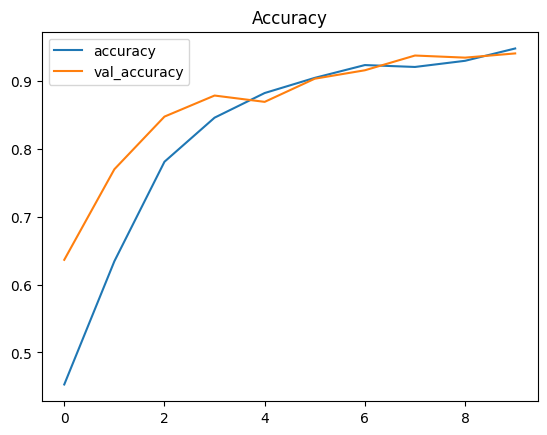

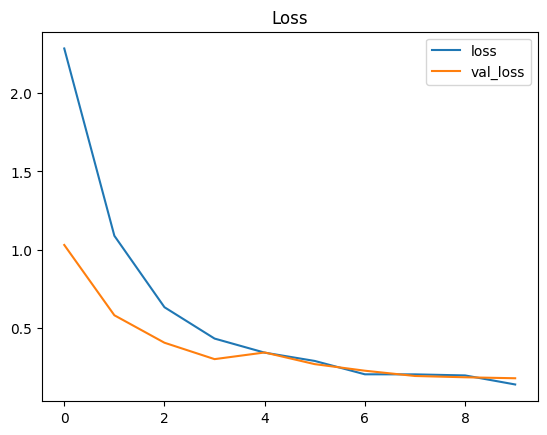

In [5]:
# 5) Plot Accuracy & Loss
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(title="Accuracy")
pd.DataFrame(history.history)[['loss','val_loss']].plot(title="Loss")
plt.show()

In [6]:
# 6) Evaluate on Test set
# -----------------------------------------------------------
results = model.evaluate(test_generator, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1]*100))

c:\users\thwit\appdata\local\programs\python\python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 0.31818
Test Accuracy: 93.27%


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 578ms/step
              precision    recall  f1-score   support

     Healthy     0.9815    0.9815    0.9815       108
        Rust     0.8571    1.0000    0.9231       108
        Spot     1.0000    0.7778    0.8750        81

    accuracy                         0.9327       297
   macro avg     0.9462    0.9198    0.9265       297
weighted avg     0.9413    0.9327    0.9312       297



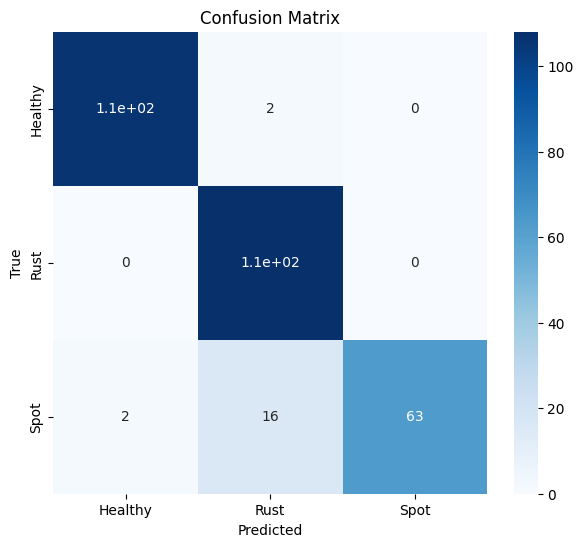

In [7]:
# 7) Confusion Matrix & Classification Report
# -----------------------------------------------------------
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

pred = model.predict(test_generator)
pred_classes = np.argmax(pred, axis=1)

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
pred_labels = [labels[k] for k in pred_classes]

true_classes = test_generator.classes

print(classification_report(true_classes, pred_classes, target_names=list(labels.values()), digits=4))

cf_matrix = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(7,6))
sns.heatmap(cf_matrix, annot=True, cmap="Blues",
            xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [8]:
# 8) Save Model
# -----------------------------------------------------------
model.save("mulberry_leaf_classification.h5")
print("Model saved as mulberry_leaf_classification.h5")


Model saved as mulberry_leaf_classification.h5


In [12]:
# 9) Predict รูปใหม่
# -----------------------------------------------------------
from tensorflow.keras.models import load_model
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess_image(img_path, target_size=(224,224)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, target_size)
    img_preprocessed = preprocess_input(np.array(img_resized, dtype=np.float32))
    img_array = np.expand_dims(img_preprocessed, axis=0)
    return img_array

# โหลดโมเดล
loaded_model = load_model("mulberry_leaf_classification.h5")

# รายชื่อ class
class_names = list(train_generator.class_indices.keys())

# ทดสอบทำนายรูปใหม่
X = preprocess_image(r"C:\Users\thwit\AI ohmmm\Mulberry Leaf Dataset\Mulberry dataset\test\Healthy\LINE_ALBUM___250922_74_jpg.rf.1928541f9e5f20a6d69c5eaa09db3301.png")   # <-- path รูปใบหม่อนใหม่
output = loaded_model.predict(X)
predicted_class = np.argmax(output)
print("Predicted class:", class_names[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicted class: Healthy
